In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
import json 

p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_features.json"

# In total 7,842 number of features
with open(p) as json_data:
    labels = json.load(json_data)

all_features = []
for idx, feature_idx in labels.items():
    features = np.zeros(7842).astype(int)
    features[feature_idx] = 1
    all_features.append(features)
    
all_features = np.array(all_features)
all_features = pd.DataFrame(all_features)
all_features.columns = [f'f{i}' for i in range(all_features.shape[1])]
all_features['index'] = [int(x) for x in labels.keys()]

labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_target.csv")
labels.columns = ['index', 'label']
labels = labels.merge(all_features)

labels.head()

,index,label,f0,f1,f2,f3,f4,f5,f6,f7,...,f7832,f7833,f7834,f7835,f7836,f7837,f7838,f7839,f7840,f7841
0,0,8,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,17,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_3591954/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{8: 0,
 17: 1,
 3: 2,
 5: 3,
 6: 4,
 0: 5,
 15: 6,
 10: 7,
 14: 8,
 13: 9,
 2: 10,
 11: 11,
 16: 12,
 7: 13,
 4: 14,
 9: 15,
 1: 16,
 12: 17}

## Exploring node features

In [5]:
import networkx as nx

g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_edges/eS1/lastfm_asia_edges.edge",
                     nodetype=int)
gcc_edges_idx = list(g.nodes)

gcc_edges_idx.sort()
gcc_edges_idx[:5]

[0, 1, 2, 3, 4]

In [6]:
data = labels
data

,index,label,f0,f1,f2,f3,f4,f5,f6,f7,...,f7832,f7833,f7834,f7835,f7836,f7837,f7838,f7839,f7840,f7841
0,0,8,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,17,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7619,7619,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7620,7620,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7621,7621,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7622,7622,17,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1


## Dimensional reduction of the nodes' features using UMAP

In [7]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["index", "label"], axis=1).values

le = preprocessing.LabelEncoder()
y = le.fit_transform(data['label'].values)

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([ 8, 17,  3, 17,  5]))

In [8]:
np.mean(X.sum(axis=1))

395.3778856243442

In [8]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

CPU times: user 58.7 s, sys: 4.07 s, total: 1min 2s
Wall time: 51.2 s


(7624, 2)

Text(0.5, 1.0, 'UMAP dim=2')

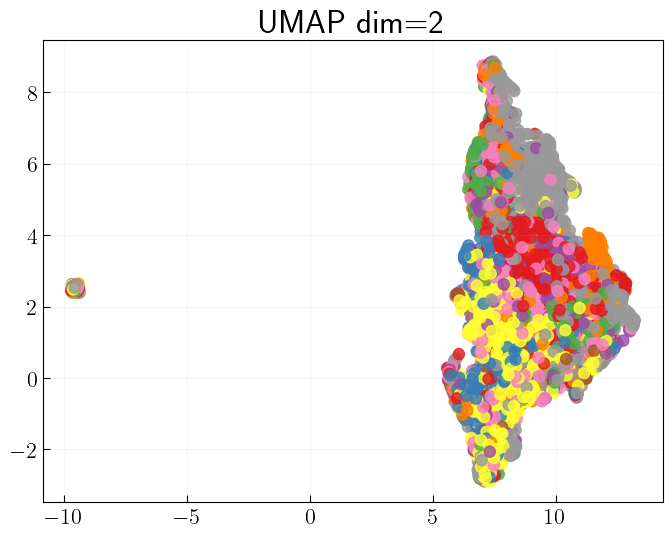

In [9]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [10]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

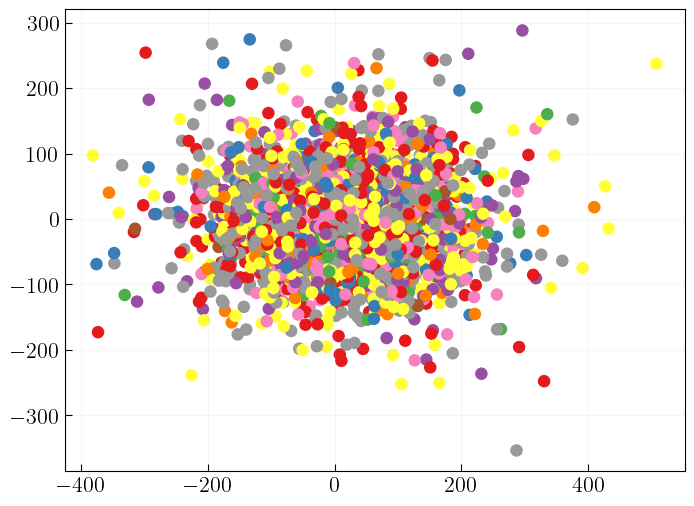

In [11]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [12]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

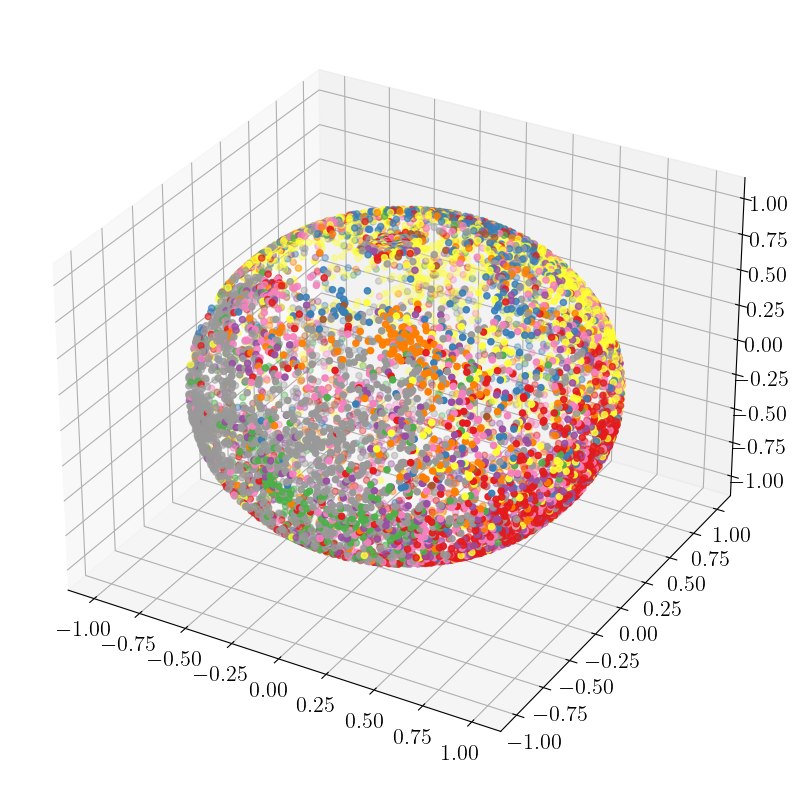

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [14]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [15]:
idx = data['index'].values
idx
# np.c_[idx, vectors]

array([   0,    1,    2, ..., 7621, 7622, 7623])

In [16]:
vectors[:10]

array([[ 6.0901964e-01,  5.1065475e-01, -6.0689938e-01],
       [-7.5968057e-01,  4.7626942e-01, -4.4277856e-01],
       [ 8.9630932e-01,  3.7848777e-01,  2.3103365e-01],
       [-2.1805917e-01, -8.5285932e-01, -4.7442719e-01],
       [-4.9538764e-01,  7.8850240e-01,  3.6449286e-01],
       [-3.2426611e-01, -2.5892767e-04, -9.4596589e-01],
       [-1.7313592e-01,  5.3718504e-02,  9.8343188e-01],
       [ 1.9469273e-01, -9.0790749e-01, -3.7121257e-01],
       [ 7.9635864e-01,  9.9379405e-02, -5.9660435e-01],
       [ 2.1259129e-01,  4.8033836e-01, -8.5092890e-01]], dtype=float32)

In [17]:
# F-Mercator

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/umap_lastfm_spherical_positions.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [18]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 1min 26s, sys: 2.2 s, total: 1min 28s
Wall time: 1min 12s


  0%|          | 0/7624 [00:00<?, ?it/s]/home/rob/repo/hyperbolic-nodes-features-embedding/notebooks/../lib/check_inferred_embeddings.py:61: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  np.arccos(np.dot(v, u) / (np.linalg.norm(v) * np.linalg.norm(u))))
/home/rob/repo/hyperbolic-nodes-features-embedding/notebooks/../lib/check_inferred_embeddings.py:61: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  np.arccos(np.dot(v, u) / (np.linalg.norm(v) * np.linalg.norm(u))))
100%|██████████| 7624/7624 [39:57<00:00,  3.18it/s]  


The best Z-axis rotation angle:  2.179880616776591


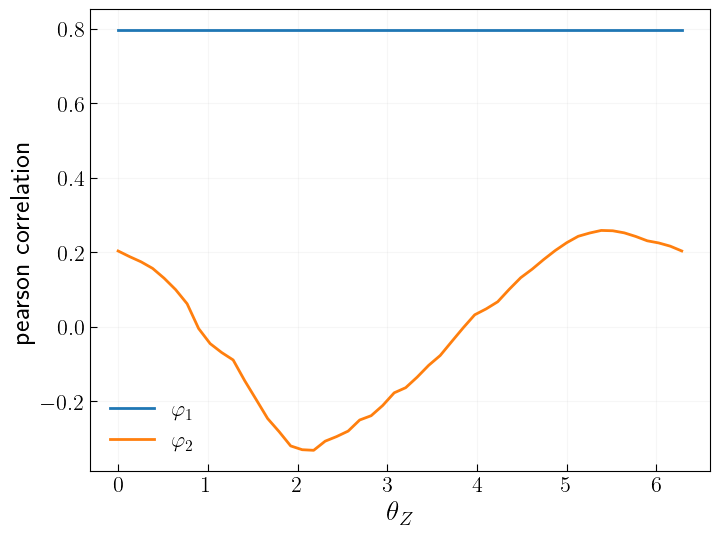

In [19]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2, )

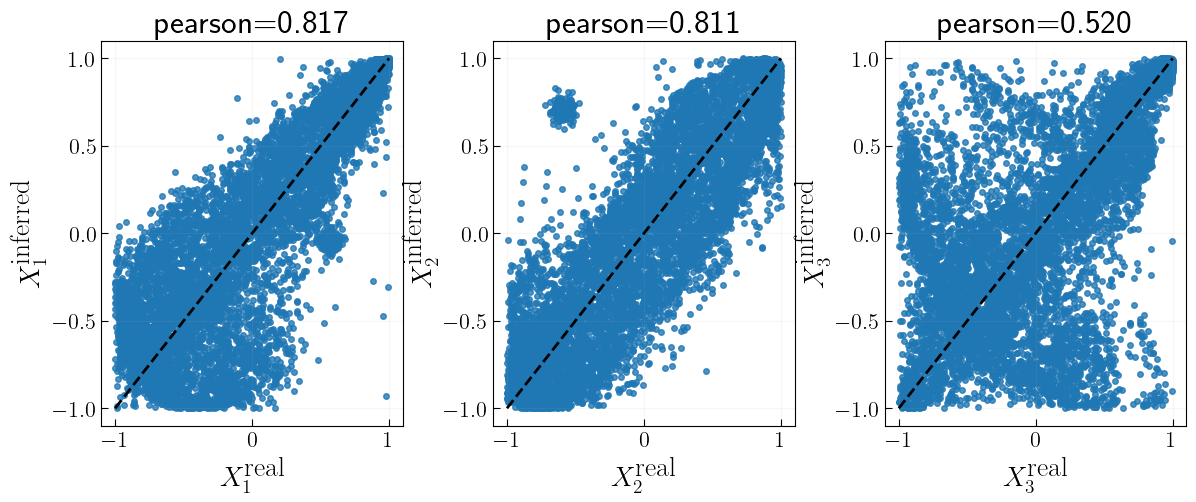

In [20]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)